# play with sift

In [1]:
import cv2 
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [2]:
#images
images = []
for i in range(65):
    read_path = os.path.join('bigpic', str(i) + '.' + 'png')
    images.append(cv2.imread(read_path,0))

In [3]:
len(images)

65

In [4]:
images[0].shape

(300, 300)

In [5]:
cv2.__version__

'4.5.1'

In [6]:
sift = cv2.xfeatures2d.SIFT_create()

In [7]:
FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv2.FlannBasedMatcher(indexParams, searchParams)

In [8]:
kp1,des1 = sift.detectAndCompute(images[8],None)
kp2,des2 = sift.detectAndCompute(images[19],None)
matches = flann.knnMatch(des1,des2,k=2)
goodMatches = []
for m,n in matches:
    if m.distance < 0.5*n.distance and m not in goodMatches and m.distance > 0:
        goodMatches.append([m]) 
img_out = cv2.drawMatchesKnn(images[8], kp1, images[19], kp2, goodMatches, None, flags=2)
cv2.imshow('image', img_out)
cv2.waitKey(0)
cv2.destroyAllWindows()

the sift keypoints are not reliable in this case, their are 2 reasons: 
1.  the picture is too small(16 * 16) to do sift
2.  after resize the images to a larger images, there are many jagged shapes on the edges of the characters. and unfortunatly, sift will focus more on these shapes.
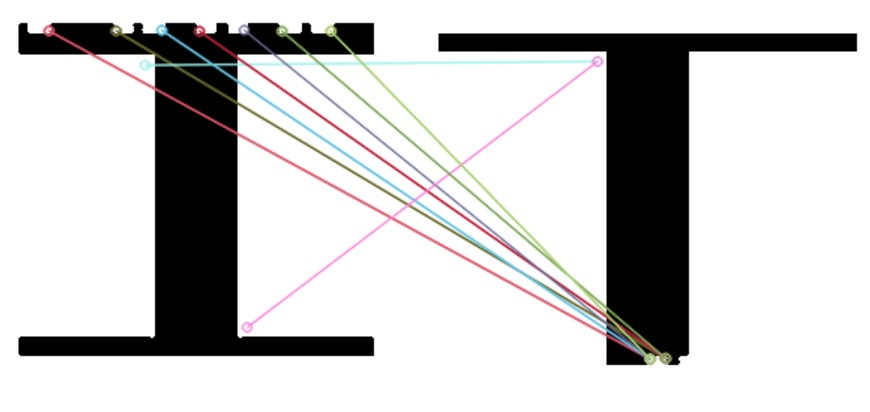
but anyway, let's try it.

In [9]:
# after run, save the smilarity as a npy file
# similarity = [[0 for _ in range(65)] for _ in range(65)]
# for i in range(65):
#     for j in range(65):
#         print(i, j)
#         kp1,des1 = sift.detectAndCompute(images[i],None)
#         kp2,des2 = sift.detectAndCompute(images[j],None)
#         matches = flann.knnMatch(des1,des2,k=2)
#         goodMatches = []
#         for m,n in matches:
#             if m.distance < 0.5*n.distance and m not in goodMatches:
#                 goodMatches.append([m]) 
#         percent = len(goodMatches)/(len(kp2) + len(kp1) - len(goodMatches))
#         similarity[i][j] = percent

In [10]:
similarity = np.load('similarity.npy')

In [11]:
similarity = np.array(similarity)

In [12]:
np.argsort(sum(similarity))

array([62, 25, 12, 23,  0, 49, 10, 61, 59, 38, 22, 18, 50, 36, 47, 60,  1,
       33, 54, 64, 30, 52, 40, 16, 51,  8,  9, 14, 27, 55, 13, 21,  3, 37,
        2, 32,  6, 42, 20, 17, 43, 29, 57, 48, 46, 58, 53, 41, 24,  5, 26,
       35,  7, 44, 31, 15,  4, 56, 28, 19, 39, 45, 11, 63, 34],
      dtype=int64)

In [13]:
# np.save('similarity.npy', similarity)

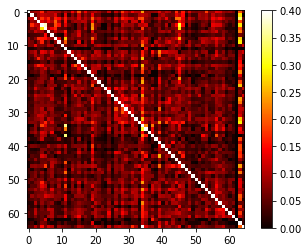

In [14]:
import matplotlib.pyplot as plt

plt.imshow(similarity, cmap=plt.cm.hot, vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

# Trianing and evaluating process

In [15]:
import tensorflow as tf 
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

In [16]:
label2name = []
for i in range(65, 91):
    label2name.append(chr(i))
for i in range(97, 123):
    label2name.append(chr(i))
for i in range(49, 58):
    label2name.append(chr(i))
label2name.extend(['0', ':', '!', '"'])


In [17]:
# train_idx = np.argsort(sum(similarity))[:32]
# test_idx = np.argsort(sum(similarity))[32:64]
train_img = ['A', 'B','C','D','E','H','I','K','L','M','N','O','P','Q','R','S','U','V','W','X','Y','Z','b','d','e','g','h','i','l','t','4',':']

test_img = ['F','G','J','T','a','c','f','j','k','m','n','o','p','q','r','s','u','v','w','x','y','z','1','2','3','5','6','7','8','9','0','!']


In [18]:
train_idx = [label2name.index(img) for img in train_img]
test_idx = [label2name.index(img) for img in test_img]

In [19]:
images_small = [cv2.resize(images[i], (16, 16)) for i in range(65)]

## split the train and test set

In [20]:
def get_dataset1(train_idx, test_idx, add_noise):
    train_set = [images_small[i] for i in train_idx]
    test_set = [images_small[i] for i in test_idx]
    train_label = np.array([[0] * 65 for i in range(32)])
    test_label = np.array([[0] * 65 for i in range(32)])
    train_label.shape
    for i in range(32):
        train_set[i] = np.reshape(train_set[i] / 255, (256, )).astype('int').astype('float64')
        train_label[i][train_idx[i]] = 1   
    train_set = np.array(train_set)

    for i in range(32):
        test_set[i] = np.reshape(test_set[i] / 255, (256, )).astype('int').astype('float64')
        test_label[i][test_idx[i]] = 1
    test_set = np.array(test_set)


    # get Fh and Fha
    Fh = {}
    Fha = {}

    for i in range(64):
        for j in range(64):
            arr1 = np.reshape(images_small[i] / 255, (256, )).astype('int')
            arr2 = np.reshape(images_small[j] / 255, (256, )).astype('int')
            hit = np.sum((1-arr1) & (1-arr2))
            total = np.sum(1-arr1)
            pred = np.sum(1-arr2)
            Fh[str(i)+str(j)] = hit / total
            Fha[str(i)+str(j)] = (pred-hit) / pred


    # add noise
    if add_noise:
        idx = np.arange(256)
        for i in range(32):
            noise = np.random.normal(0.0, add_noise, 25)
            idx = np.random.permutation(idx)
            for j in range(25):
                train_set[i][idx[j]] += noise[j]

        for i in range(32):
            noise = np.random.normal(0.0, add_noise, 25)
            idx = np.random.permutation(idx)
            for j in range(25):
                test_set[i][idx[j]] += noise[j]
    
    min_ = np.min(train_set, keepdims=True)
    max_ = np.max(train_set, keepdims=True)
    train_x = (train_set - min_) / max_
    test_x = (test_set - min_) / max_

    return train_set, train_label, test_set, test_label, Fh, Fha


In [21]:
train_set, train_label, test_set, test_label, Fh, Fha = get_dataset1(train_idx, test_idx, 0.01)

## using method 1: predict cls index

In [22]:
def get_model_approach_1():
    img_input = tf.keras.Input(shape=(256, ))
    hidden1 = Dense(512, activation='relu')(img_input)
    hidden2 = Dense(128, activation='relu')(hidden1)
    output = Dense(65, activation='softmax')(hidden2)
    model = tf.keras.Model(img_input, output)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
model = get_model_approach_1()

In [24]:
history = model.fit(train_set, train_label, batch_size=10, epochs=100, verbose=1, validation_split=0.5)

Epoch 1/100
2/2 [==============================] - 0s 151ms/step - loss: 4.4179 - accuracy: 0.0000e+00 - val_loss: 4.2393 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 4.1588 - accuracy: 0.0000e+00 - val_loss: 4.2931 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 14ms/step - loss: 3.9511 - accuracy: 0.1250 - val_loss: 4.3504 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 25ms/step - loss: 3.7827 - accuracy: 0.0625 - val_loss: 4.4027 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 3.6210 - accuracy: 0.0625 - val_loss: 4.4567 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 21ms/step - loss: 3.4867 - accuracy: 0.0625 - val_loss: 4.5158 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 26ms/step - loss: 3.3595 - accuracy: 0.1250 - val_loss: 4.5755 - val_accu

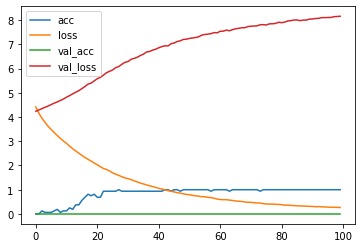

In [25]:
def plot_history1(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    x = np.arange(100)
    plt.plot(x, acc, label='acc')
    plt.plot(x, loss, label='loss')
    plt.plot(x, val_acc, label='val_acc')
    plt.plot(x, val_loss, label='val_loss')
    plt.legend()
    plt.show()
plot_history1(history)

In [26]:
print('now test the model on the test set')
pred = model.predict(test_set)
cnt = 0
fhs = []
fhas = []
for i in range(32):
    y_pred = np.argmax(pred[i])
    y_true = np.argmax(test_label[i])

    print('truth: ',  label2name[y_true], '  pred: ', label2name[y_pred], 'Fh: ', format(Fh[str(y_true)+str(y_pred)], '.2f'), 'Fha: ', format(Fha[str(y_true)+str(y_pred)], '.2f'))
    fhs.append(format(Fh[str(y_true)+str(y_pred)], '.2f'))
    fhas.append(format(Fha[str(y_true)+str(y_pred)], '.2f'))
    if y_pred == y_true:
        cnt += 1

print('acc: ', cnt / 10)

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  N Fh:  0.78 Fha:  0.46
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  S Fh:  0.33 Fha:  0.72
truth:  k   pred:  R Fh:  0.87 Fha:  0.32
truth:  m   pred:  M Fh:  0.54 Fha:  0.43
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  H Fh:  0.63 Fha:  0.42
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  N Fh:  0.65 Fha:  0.63
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  P Fh:  0.41 Fha:  0.76
truth:  w   pred:  H Fh:  0.56 Fha:  0.52
truth:  x   pred:  S Fh:  0.38 Fha:  0.70
truth:  y   pred:  M Fh:  0.38 Fha:  0.78
truth:  z   pred:  S Fh:  0.37 Fha:  0.72
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

In [27]:
def train_process1(train_idx, test_idx, add_noise, verbose=False):
    model = get_model_approach_1()
    train_set, train_label, test_set, test_label, Fh, Fha = get_dataset1(train_idx, test_idx, add_noise)
    history = model.fit(train_set, train_label, batch_size=10, epochs=100, verbose=verbose, validation_split=0.5)
    plot_history1(history)
    print('now test the model on the test set')
    pred = model.predict(test_set)
    cnt = 0
    fhs = []
    fhas = []
    for i in range(32):
        y_pred = np.argmax(pred[i])
        y_true = np.argmax(test_label[i])

        print('truth: ',  label2name[y_true], '  pred: ', label2name[y_pred], 'Fh: ', format(Fh[str(y_true)+str(y_pred)], '.2f'), 'Fha: ', format(Fha[str(y_true)+str(y_pred)], '.2f'))
        fhs.append(format(Fh[str(y_true)+str(y_pred)], '.2f'))
        fhas.append(format(Fha[str(y_true)+str(y_pred)], '.2f'))
        if y_pred == y_true:
            cnt += 1

    print('acc: ', cnt / 10)
    return fhs, fhas

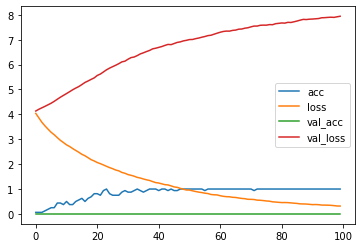

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  A Fh:  0.52 Fha:  0.63
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  N Fh:  0.78 Fha:  0.46
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  C Fh:  0.18 Fha:  0.81
truth:  k   pred:  K Fh:  0.82 Fha:  0.29
truth:  m   pred:  O Fh:  0.52 Fha:  0.41
truth:  n   pred:  N Fh:  0.89 Fha:  0.40
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  L Fh:  0.33 Fha:  0.45
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  L Fh:  0.38 Fha:  0.55
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  C Fh:  0.38 Fha:  0.69
truth:  w   pred:  O Fh:  0.54 Fha:  0.50
truth:  x   pred:  C Fh:  0.22 Fha:  0.79
truth:  y   pred:  C Fh:  0.12 Fha:  0.88
truth:  z   pred:  L Fh:  0.40 Fha:  0.61
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

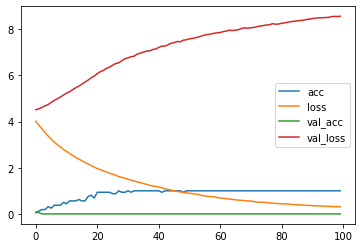

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  H Fh:  0.72 Fha:  0.42
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  L Fh:  0.62 Fha:  0.14
truth:  m   pred:  O Fh:  0.52 Fha:  0.41
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  H Fh:  0.63 Fha:  0.42
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  L Fh:  0.38 Fha:  0.55
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  C Fh:  0.38 Fha:  0.69
truth:  w   pred:  C Fh:  0.29 Fha:  0.58
truth:  x   pred:  S Fh:  0.38 Fha:  0.70
truth:  y   pred:  I Fh:  0.21 Fha:  0.82
truth:  z   pred:  I Fh:  0.49 Fha:  0.62
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

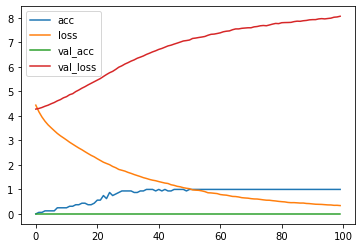

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  H Fh:  0.72 Fha:  0.42
truth:  c   pred:  E Fh:  0.62 Fha:  0.61
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  L Fh:  0.62 Fha:  0.14
truth:  m   pred:  M Fh:  0.54 Fha:  0.43
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  N Fh:  0.68 Fha:  0.46
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  L Fh:  0.38 Fha:  0.55
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  E Fh:  0.36 Fha:  0.77
truth:  w   pred:  C Fh:  0.29 Fha:  0.58
truth:  x   pred:  E Fh:  0.38 Fha:  0.73
truth:  y   pred:  L Fh:  0.15 Fha:  0.84
truth:  z   pred:  E Fh:  0.51 Fha:  0.65
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

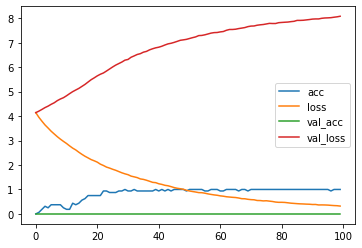

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  N Fh:  0.78 Fha:  0.46
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  L Fh:  0.62 Fha:  0.14
truth:  m   pred:  M Fh:  0.54 Fha:  0.43
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  H Fh:  0.63 Fha:  0.42
truth:  r   pred:  A Fh:  0.53 Fha:  0.65
truth:  s   pred:  L Fh:  0.38 Fha:  0.55
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  L Fh:  0.31 Fha:  0.73
truth:  w   pred:  N Fh:  0.62 Fha:  0.54
truth:  x   pred:  R Fh:  0.67 Fha:  0.62
truth:  y   pred:  I Fh:  0.21 Fha:  0.82
truth:  z   pred:  L Fh:  0.40 Fha:  0.61
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

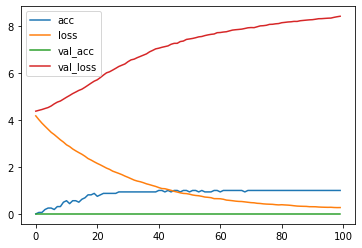

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  H Fh:  0.72 Fha:  0.42
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  L Fh:  0.62 Fha:  0.14
truth:  m   pred:  O Fh:  0.52 Fha:  0.41
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  C Fh:  0.27 Fha:  0.58
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  L Fh:  0.38 Fha:  0.55
truth:  u   pred:  L Fh:  0.50 Fha:  0.30
truth:  v   pred:  C Fh:  0.38 Fha:  0.69
truth:  w   pred:  O Fh:  0.54 Fha:  0.50
truth:  x   pred:  K Fh:  0.53 Fha:  0.66
truth:  y   pred:  S Fh:  0.25 Fha:  0.79
truth:  z   pred:  L Fh:  0.40 Fha:  0.61
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

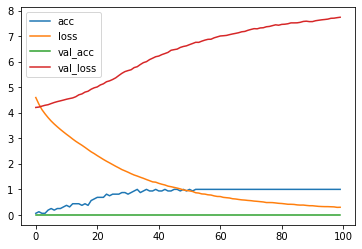

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  A Fh:  0.52 Fha:  0.63
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  N Fh:  0.78 Fha:  0.46
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  K Fh:  0.82 Fha:  0.29
truth:  m   pred:  O Fh:  0.52 Fha:  0.41
truth:  n   pred:  N Fh:  0.89 Fha:  0.40
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  N Fh:  0.68 Fha:  0.46
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  S Fh:  0.46 Fha:  0.58
truth:  u   pred:  N Fh:  0.87 Fha:  0.41
truth:  v   pred:  A Fh:  0.33 Fha:  0.80
truth:  w   pred:  O Fh:  0.54 Fha:  0.50
truth:  x   pred:  R Fh:  0.67 Fha:  0.62
truth:  y   pred:  A Fh:  0.23 Fha:  0.83
truth:  z   pred:  L Fh:  0.40 Fha:  0.61
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

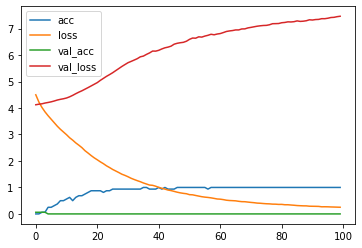

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  H Fh:  0.72 Fha:  0.42
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  C Fh:  0.55 Fha:  0.40
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  K Fh:  0.82 Fha:  0.29
truth:  m   pred:  O Fh:  0.52 Fha:  0.41
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  H Fh:  0.63 Fha:  0.42
truth:  r   pred:  C Fh:  0.42 Fha:  0.62
truth:  s   pred:  C Fh:  0.31 Fha:  0.67
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  C Fh:  0.38 Fha:  0.69
truth:  w   pred:  K Fh:  0.50 Fha:  0.51
truth:  x   pred:  K Fh:  0.53 Fha:  0.66
truth:  y   pred:  A Fh:  0.23 Fha:  0.83
truth:  z   pred:  I Fh:  0.49 Fha:  0.62
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

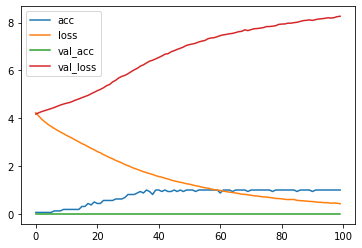

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  S Fh:  0.54 Fha:  0.56
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  H Fh:  0.72 Fha:  0.42
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  C Fh:  0.55 Fha:  0.40
truth:  j   pred:  C Fh:  0.18 Fha:  0.81
truth:  k   pred:  L Fh:  0.62 Fha:  0.14
truth:  m   pred:  A Fh:  0.34 Fha:  0.55
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  Q Fh:  0.75 Fha:  0.49
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  H Fh:  0.63 Fha:  0.42
truth:  r   pred:  L Fh:  0.44 Fha:  0.57
truth:  s   pred:  L Fh:  0.38 Fha:  0.55
truth:  u   pred:  D Fh:  0.77 Fha:  0.39
truth:  v   pred:  L Fh:  0.31 Fha:  0.73
truth:  w   pred:  D Fh:  0.56 Fha:  0.52
truth:  x   pred:  A Fh:  0.47 Fha:  0.68
truth:  y   pred:  L Fh:  0.15 Fha:  0.84
truth:  z   pred:  I Fh:  0.49 Fha:  0.62
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

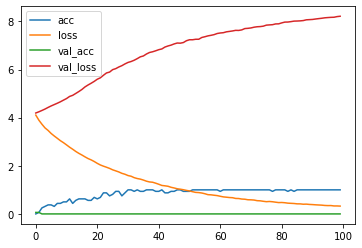

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  A Fh:  0.52 Fha:  0.63
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  N Fh:  0.78 Fha:  0.46
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  I Fh:  0.33 Fha:  0.71
truth:  k   pred:  R Fh:  0.87 Fha:  0.32
truth:  m   pred:  M Fh:  0.54 Fha:  0.43
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  L Fh:  0.41 Fha:  0.48
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  N Fh:  0.68 Fha:  0.46
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  S Fh:  0.46 Fha:  0.58
truth:  u   pred:  H Fh:  0.84 Fha:  0.34
truth:  v   pred:  L Fh:  0.31 Fha:  0.73
truth:  w   pred:  Q Fh:  0.53 Fha:  0.56
truth:  x   pred:  A Fh:  0.47 Fha:  0.68
truth:  y   pred:  S Fh:  0.25 Fha:  0.79
truth:  z   pred:  I Fh:  0.49 Fha:  0.62
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

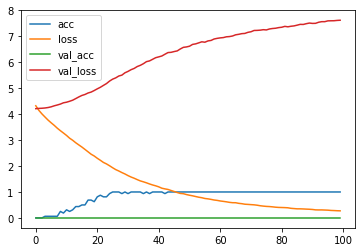

now test the model on the test set
truth:  F   pred:  E Fh:  1.00 Fha:  0.15
truth:  G   pred:  C Fh:  0.73 Fha:  0.02
truth:  J   pred:  A Fh:  0.52 Fha:  0.63
truth:  T   pred:  I Fh:  0.96 Fha:  0.18
truth:  a   pred:  N Fh:  0.78 Fha:  0.46
truth:  c   pred:  C Fh:  0.56 Fha:  0.54
truth:  f   pred:  E Fh:  0.74 Fha:  0.37
truth:  j   pred:  S Fh:  0.33 Fha:  0.72
truth:  k   pred:  L Fh:  0.62 Fha:  0.14
truth:  m   pred:  I Fh:  0.35 Fha:  0.46
truth:  n   pred:  H Fh:  0.85 Fha:  0.33
truth:  o   pred:  O Fh:  0.77 Fha:  0.42
truth:  p   pred:  L Fh:  0.45 Fha:  0.25
truth:  q   pred:  L Fh:  0.33 Fha:  0.45
truth:  r   pred:  E Fh:  0.72 Fha:  0.50
truth:  s   pred:  S Fh:  0.46 Fha:  0.58
truth:  u   pred:  L Fh:  0.50 Fha:  0.30
truth:  v   pred:  L Fh:  0.31 Fha:  0.73
truth:  w   pred:  C Fh:  0.29 Fha:  0.58
truth:  x   pred:  S Fh:  0.38 Fha:  0.70
truth:  y   pred:  S Fh:  0.25 Fha:  0.79
truth:  z   pred:  L Fh:  0.40 Fha:  0.61
truth:  1   pred:  I Fh:  0.92 Fha:  0.16

In [28]:
matrix = []
dev = [0, 0.001, 0.002, 0.003, 0.005,  0.01, 0.02, 0.03, 0.05, 0.1]  
for d in dev:
    fhs, fhas = train_process1(train_idx, test_idx, d)
    matrix.append(fhs)
    matrix.append(fhas)
matrix = np.transpose(np.array(matrix))
print(matrix)
samples = [label2name[i] for i in test_idx]

header = []
for n in dev:
    header.append((str(n), 'Fh'))
    header.append((str(n), 'Fha'))
print(header)
header = pd.MultiIndex.from_tuples(header)
df = pd.DataFrame(matrix, dtype='float', index=samples, columns=header)
df = df.round(2)
df.to_excel("metric_1.xlsx", index = True, header=True)

print(matrix)
print(samples)

In [29]:
cols = []
for n in dev:
    cols.append((str(n), 'Fh'))
test_Fh = np.transpose(df[cols].values)
cols = []
for n in dev:
    cols.append((str(n), 'Fha'))
test_Fha = np.transpose(df[cols].values)

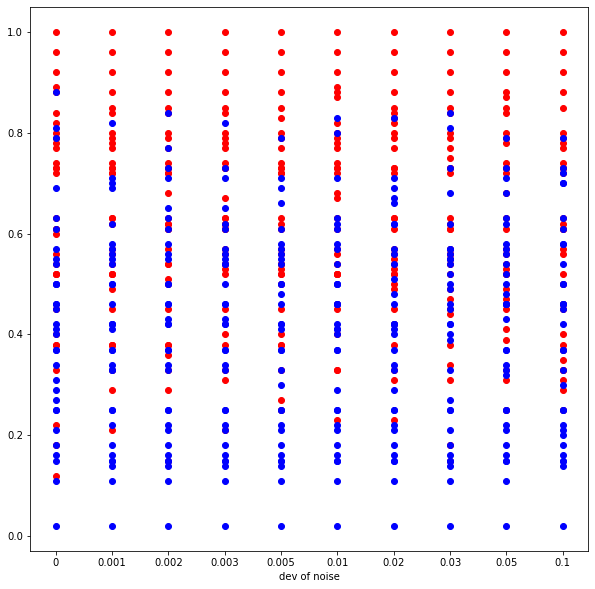

In [30]:
plt.figure(figsize=(10, 10))

for i in range(10):
    fh = test_Fh[i]
    fha = test_Fha[i]
    plt.scatter([i]*32, fh, color='r')
    plt.scatter([i]*32, fha, color='b')

plt.xticks(np.arange(10), dev)
plt.xlabel('dev of noise')
plt.show()

## method 2:  predict the images.

In [31]:
def get_dataset2(train_idx, test_idx, add_noise):
    train_set = [images_small[i] for i in train_idx]
    test_set = [images_small[i] for i in test_idx]
    train_label = [images_small[i] for i in train_idx]
    test_label = [images_small[i] for i in test_idx]
    
    for i in range(32):
        train_set[i] = np.reshape(train_set[i] / 255, (256, )).astype('int').astype('float64')
        train_label[i] = np.reshape(train_label[i] / 255, (256, )).astype('int')
    train_set = np.array(train_set)
    train_label = np.array(train_label)

    for i in range(32):
        test_set[i] = np.reshape(test_set[i] / 255, (256, )).astype('int').astype('float64')
        test_label[i] = np.reshape(test_label[i] / 255, (256, )).astype('int')
    test_set = np.array(test_set)
    test_label = np.array(test_label)


    # add noise
    if add_noise:
        idx = np.arange(256)
        for i in range(32):
            noise = np.random.normal(0.0, add_noise, 25)
            idx = np.random.permutation(idx)
            for j in range(25):
                train_set[i][idx[j]] += noise[j]

        for i in range(32):
            noise = np.random.normal(0.0, add_noise, 25)
            idx = np.random.permutation(idx)
            for j in range(25):
                test_set[i][idx[j]] += noise[j]
    
    min_ = np.min(train_set, keepdims=True)
    max_ = np.max(train_set, keepdims=True)
    train_x = (train_set - min_) / max_
    test_x = (test_set - min_) / max_

    return train_set, train_label, test_set, test_label


In [32]:
train_set, train_label, test_set, test_label = get_dataset2(train_idx, test_idx, 0.01)

In [33]:
train_label[0].reshape((16, 16))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [34]:
def get_model_approach_2():
    img_input = tf.keras.Input(shape=(256, ))
    hidden1 = Dense(512, activation='relu')(img_input)
    hidden2 = Dense(512, activation='relu')(hidden1)
    output = Dense(256, activation='sigmoid')(hidden2)
    model = tf.keras.Model(img_input, output)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='MSE')
    return model

In [35]:
model = get_model_approach_2()

In [36]:
history = model.fit(train_set, train_label, batch_size=10, epochs=100, verbose=1, validation_split=0.5)

Epoch 1/100
2/2 [==============================] - 0s 86ms/step - loss: 0.2404 - val_loss: 0.2151
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 0.1847 - val_loss: 0.1936
Epoch 3/100
2/2 [==============================] - 0s 17ms/step - loss: 0.1442 - val_loss: 0.1939
Epoch 4/100
2/2 [==============================] - 0s 15ms/step - loss: 0.1275 - val_loss: 0.2001
Epoch 5/100
2/2 [==============================] - 0s 18ms/step - loss: 0.1247 - val_loss: 0.1969
Epoch 6/100
2/2 [==============================] - 0s 14ms/step - loss: 0.1188 - val_loss: 0.1874
Epoch 7/100
2/2 [==============================] - 0s 14ms/step - loss: 0.1120 - val_loss: 0.1787
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.1049 - val_loss: 0.1734
Epoch 9/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0983 - val_loss: 0.1677
Epoch 10/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0909 - val_loss: 0.1616
Epoch 11/100
2/2 [=

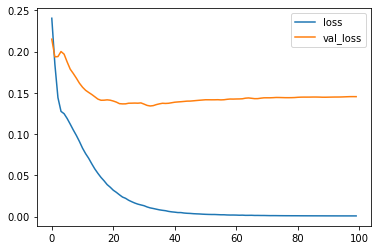

In [53]:
def plot_history2(history, epochs=100):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = np.arange(epochs)
    plt.plot(x, loss, label='loss')
    plt.plot(x, val_loss, label='val_loss')
    plt.legend()
    plt.show()

plot_history2(history)

In [38]:
from sklearn import metrics

now test the model on the test set


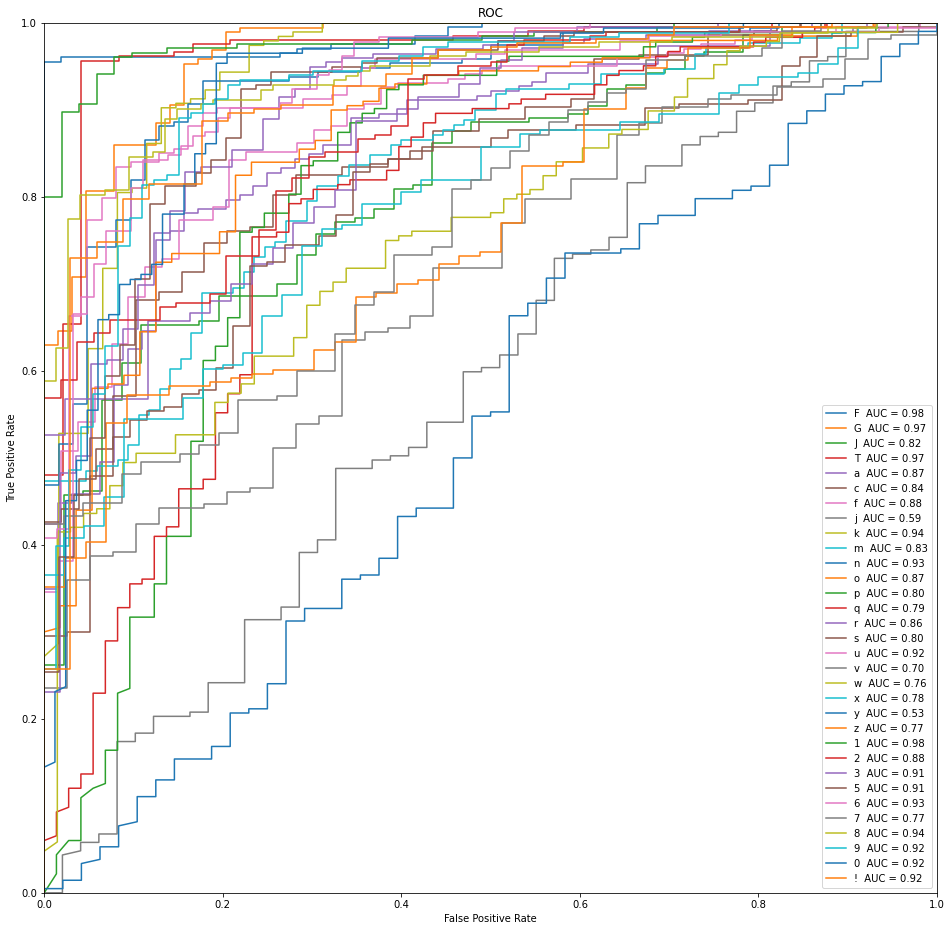

In [39]:
print('now test the model on the test set')
pred = model.predict(test_set)
plt.figure(figsize=(16, 16))
for i in range(32):
    y_pred = pred[i]
    y_true = test_label[i]
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, label = label2name[test_idx[i]]+'  AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

In [40]:
def train_process2(train_idx, test_idx, add_noise, verbose=False):
    model = get_model_approach_2()
    train_set, train_label, test_set, test_label = get_dataset2(train_idx, test_idx, add_noise)
    history = model.fit(train_set, train_label, batch_size=10, epochs=100, verbose=verbose, validation_split=0.5)
    plot_history2(history)
    
    pred = model.predict(test_set)
    plt.figure(figsize=(16, 16))
    for i in range(32):
        y_pred = pred[i]
        y_true = test_label[i]
        fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.title('ROC')
        plt.plot(fpr, tpr, label = label2name[test_idx[i]]+'  AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
    plt.show()

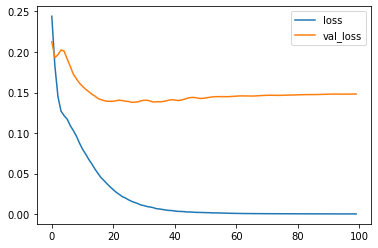

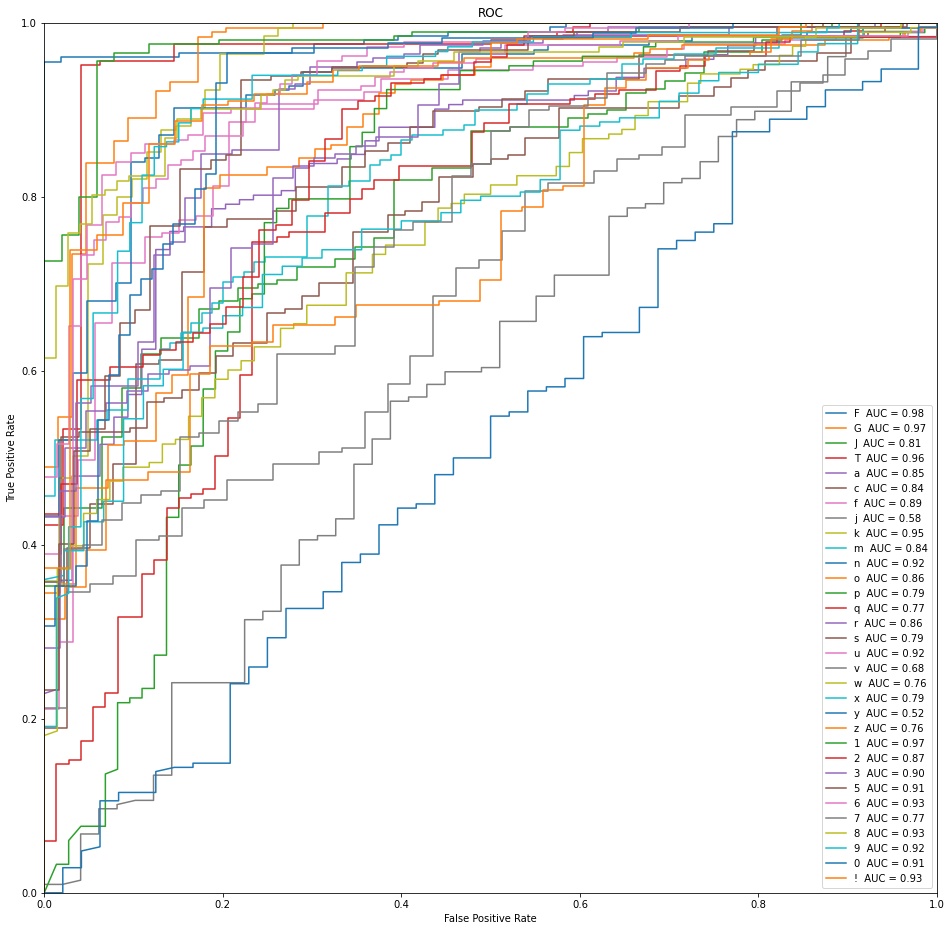

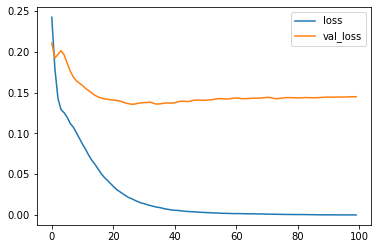

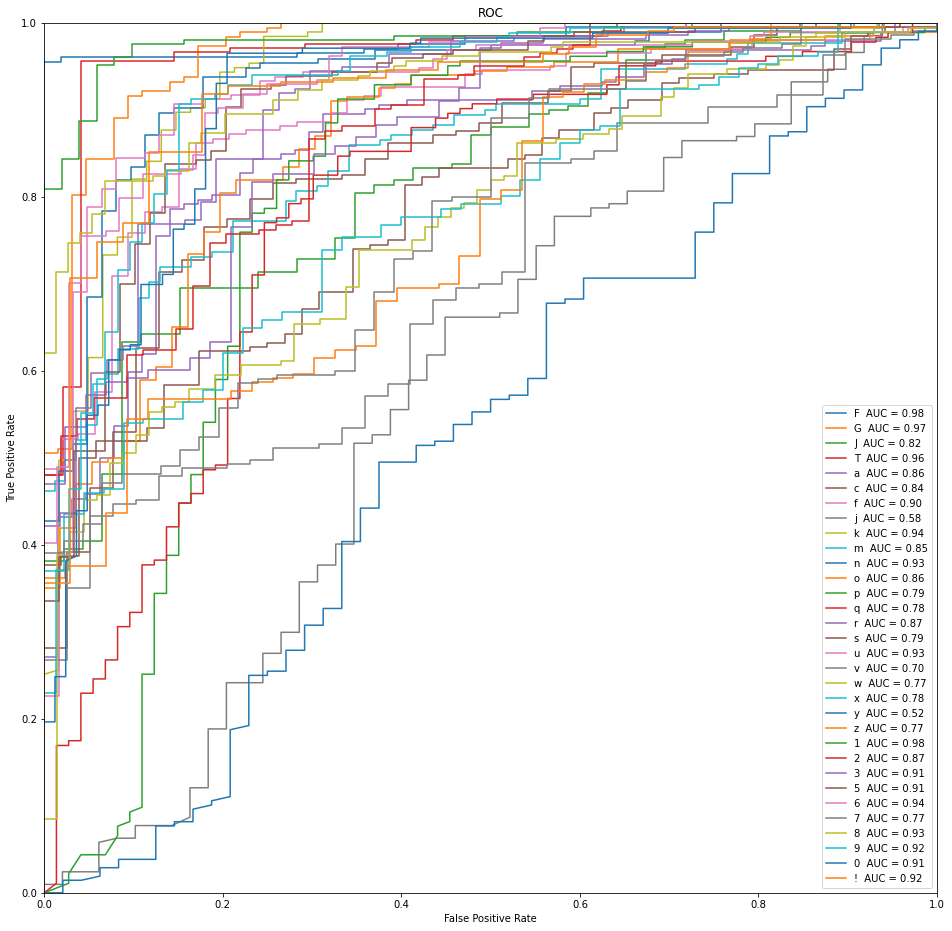

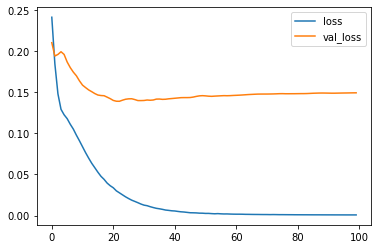

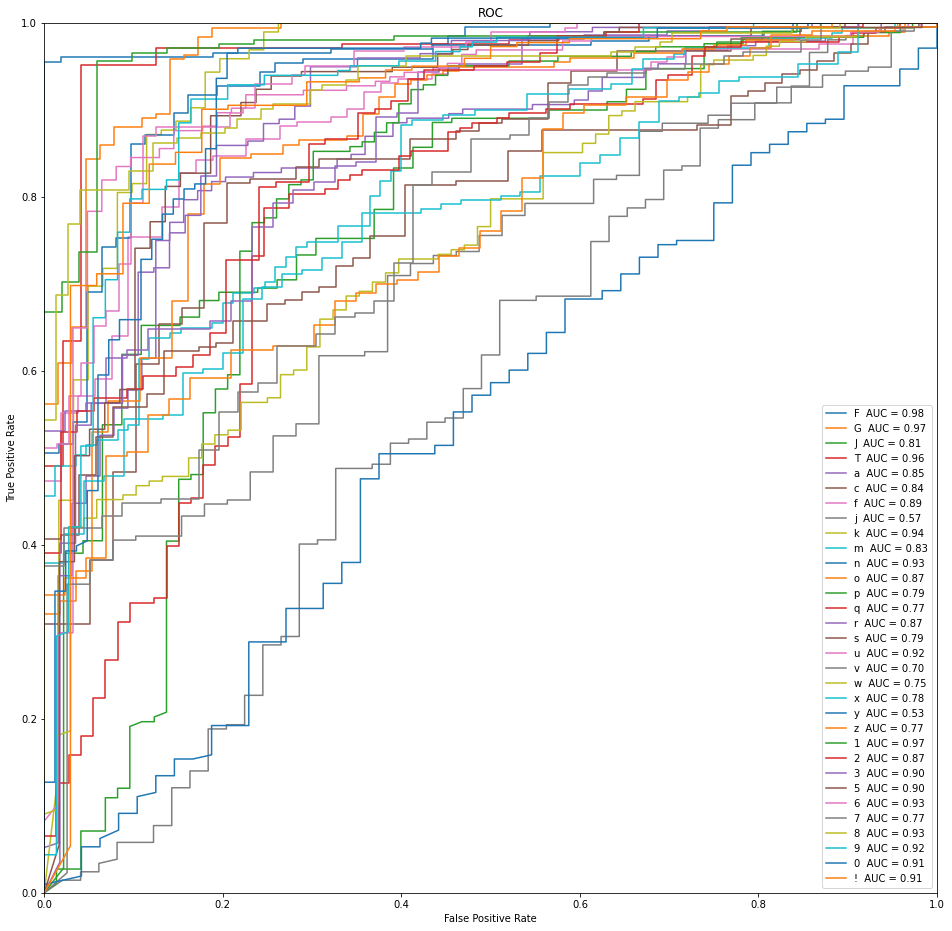

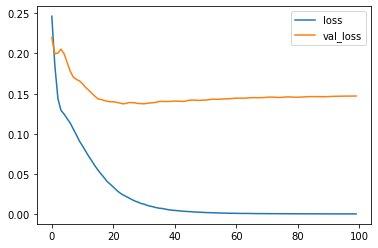

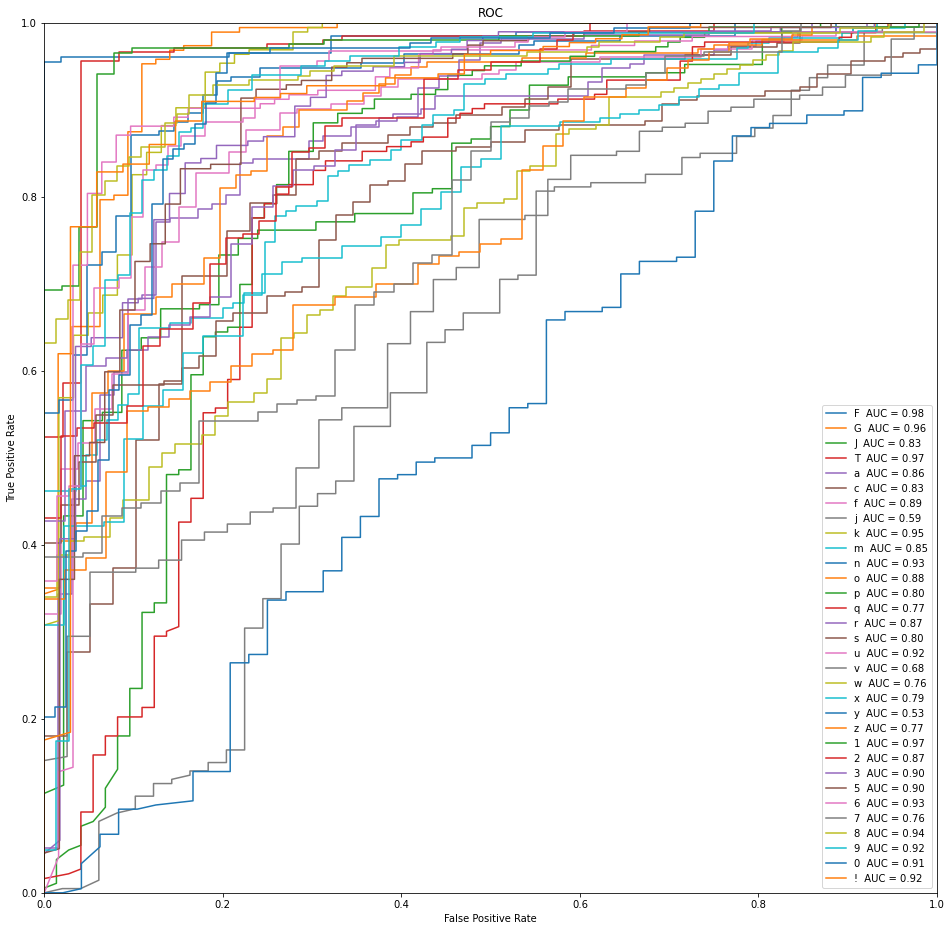

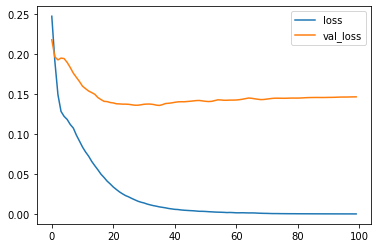

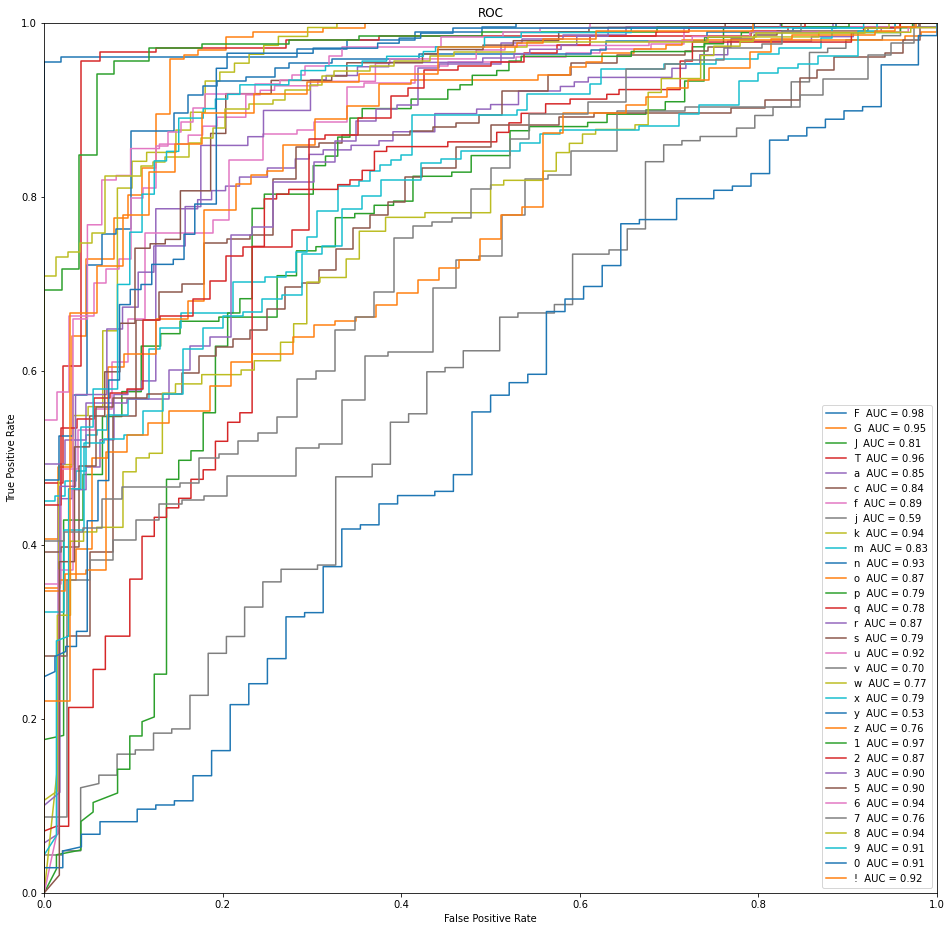

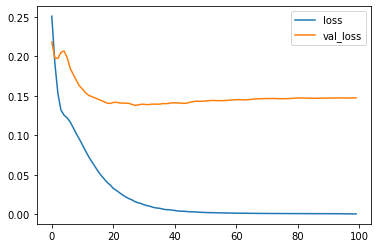

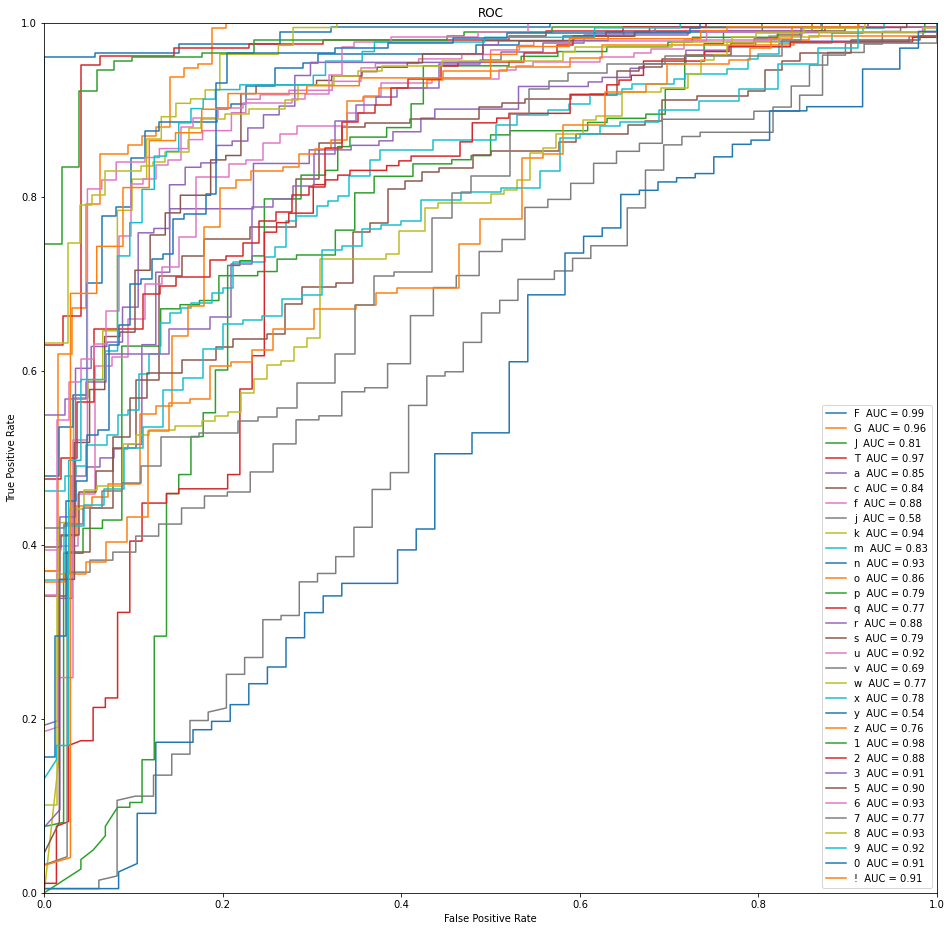

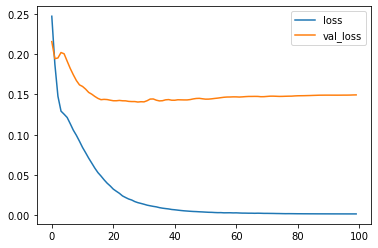

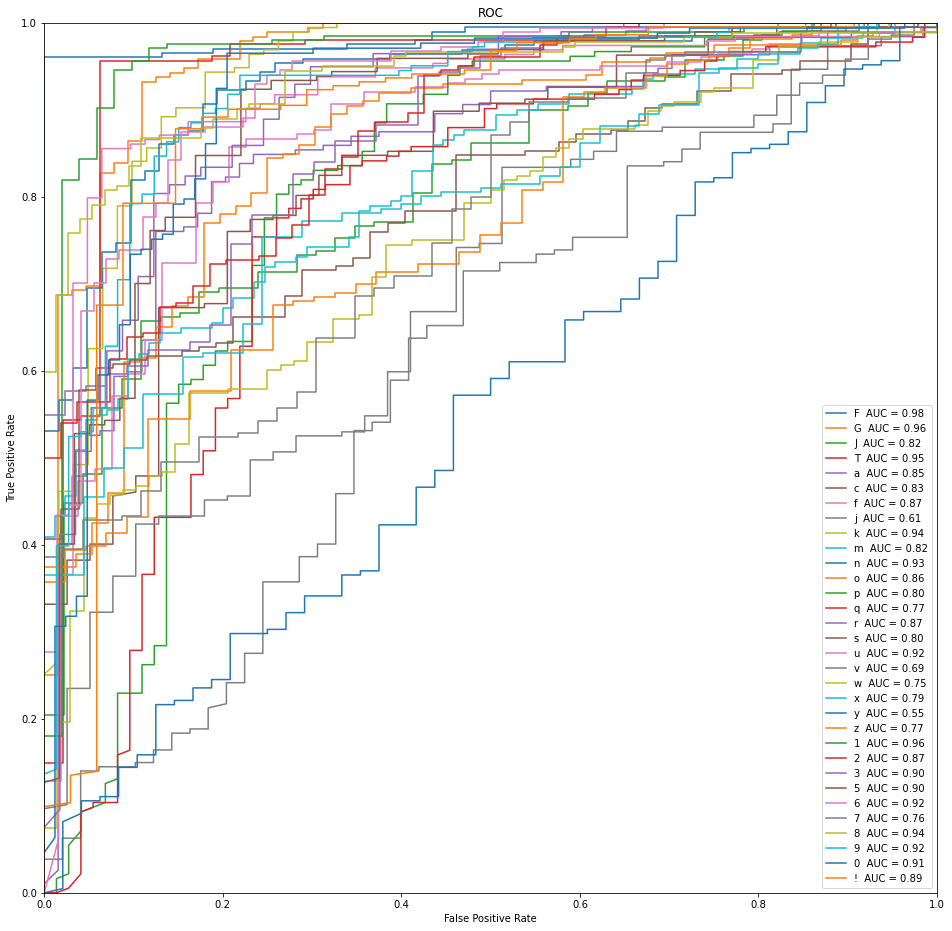

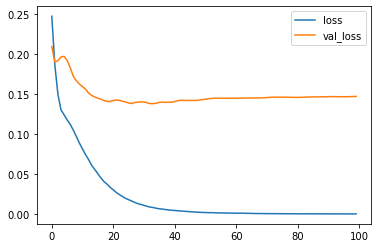

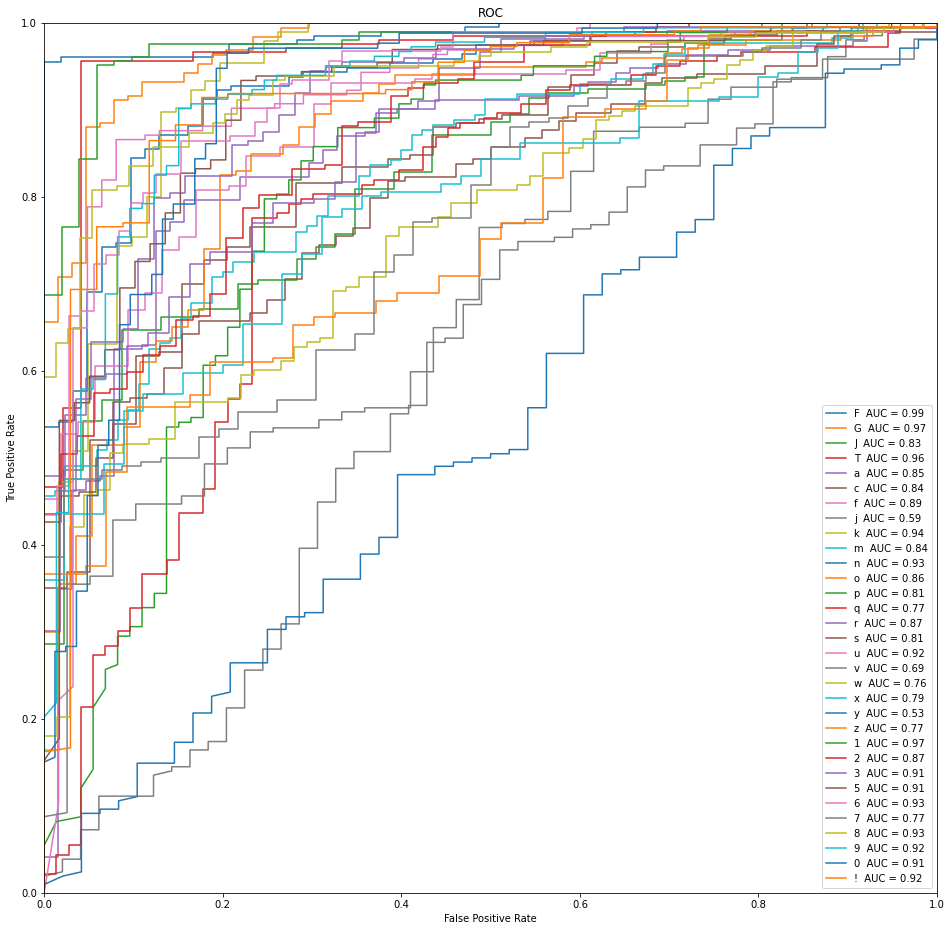

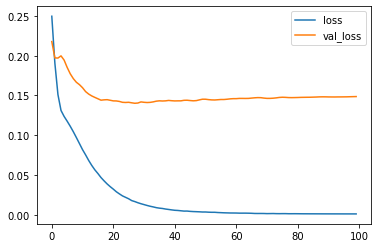

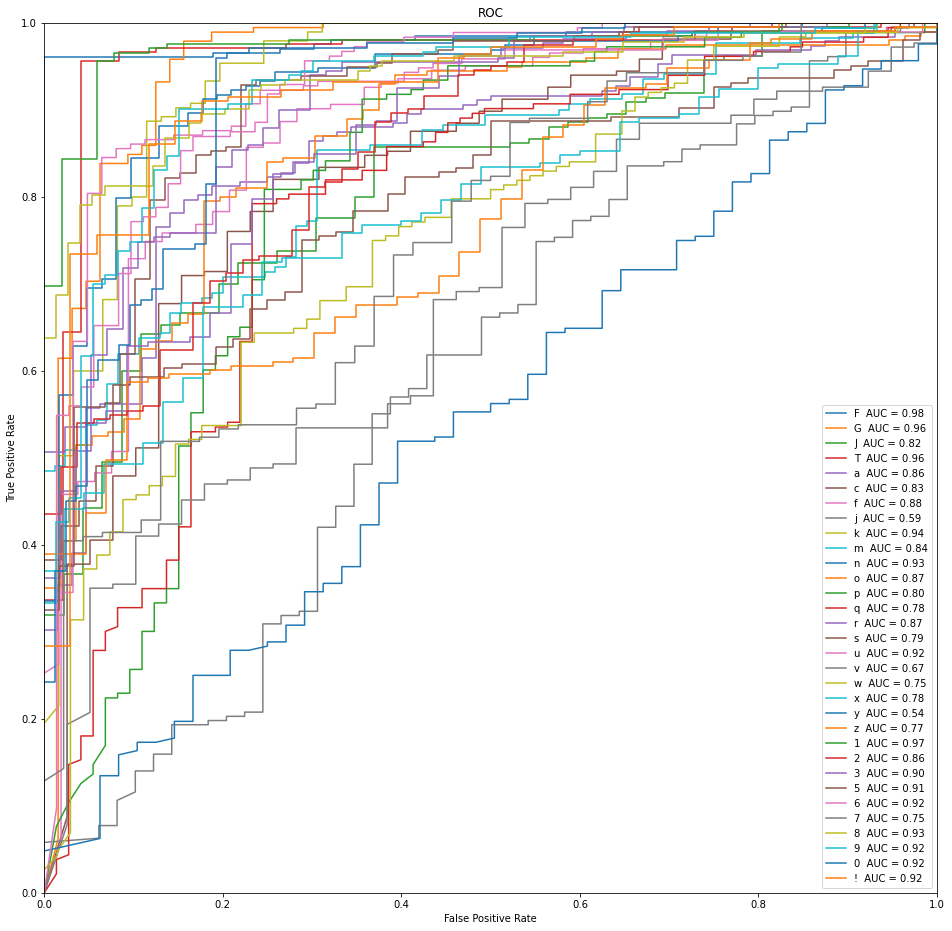

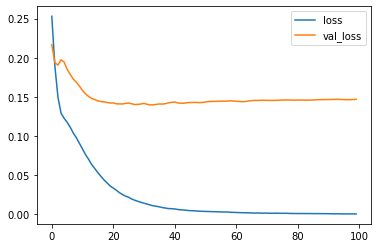

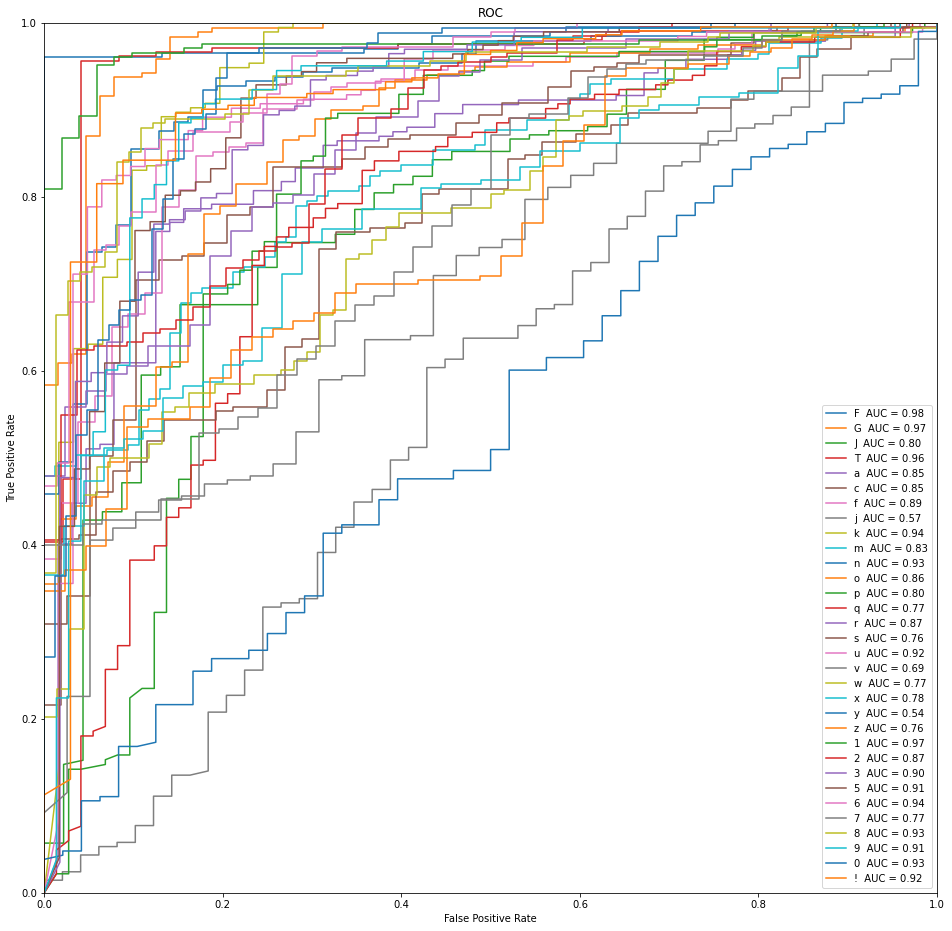

In [41]:
dev = [0, 0.001, 0.002, 0.003, 0.005,  0.01, 0.02, 0.03, 0.05, 0.1]  
for d in dev:
    train_process2(train_idx, test_idx, d)

In [56]:
def train_process3(train_idx, test_idx, add_noise, epochs=100, verbose=False):
    model = get_model_approach_2()
    train_set, train_label, test_set, test_label = get_dataset2(train_idx, test_idx, add_noise)
    history = model.fit(train_set, train_label, batch_size=10, epochs=epochs, verbose=verbose, validation_split=0.5)
    plot_history2(history, epochs)
    fhs = []
    fhas = []
    pred = model.predict(test_set)

    for i in range(32):
        y_pred = np.array([0 if pixel < 0.5 else 1 for pixel in pred[i]]).astype('int')
        y_true = test_label[i]
        y_true = y_true.astype('int')
        
        hit = np.sum((1-y_true) & (1-y_pred))
        total = np.sum(1-y_true)
        pred0 = np.sum(1-y_pred)
        Fh  = hit / total
        Fha  = (pred0-hit) / pred0

        print('label: ', label2name[test_idx[i]], 'Fh: ', format(Fh, '.2f'), 'Fha: ', format(Fha, '.2f'))
        fhs.append(Fh)
        fhas.append(Fha)
    return fhs, fhas

 14ms/step - loss: 4.9071e-04 - val_loss: 0.1524
Epoch 811/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.9070e-04 - val_loss: 0.1524
Epoch 812/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.9069e-04 - val_loss: 0.1524
Epoch 813/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.9069e-04 - val_loss: 0.1524
Epoch 814/1000
2/2 [==============================] - 0s 16ms/step - loss: 4.9068e-04 - val_loss: 0.1524
Epoch 815/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.9067e-04 - val_loss: 0.1524
Epoch 816/1000
2/2 [==============================] - 0s 17ms/step - loss: 4.9067e-04 - val_loss: 0.1524
Epoch 817/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.9066e-04 - val_loss: 0.1524
Epoch 818/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.9065e-04 - val_loss: 0.1524
Epoch 819/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.9065e-04 - val_loss: 0.1524
Epoch 

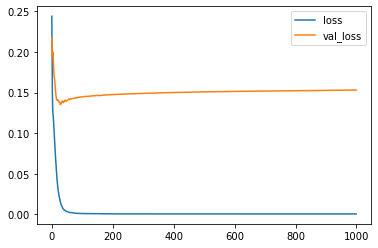

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.80 Fha:  0.02
label:  J Fh:  0.48 Fha:  0.48
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.75 Fha:  0.37
label:  c Fh:  0.54 Fha:  0.46
label:  f Fh:  0.64 Fha:  0.32
label:  j Fh:  0.27 Fha:  0.62
label:  k Fh:  0.80 Fha:  0.14
label:  m Fh:  0.41 Fha:  0.22
label:  n Fh:  0.87 Fha:  0.27
label:  o Fh:  0.64 Fha:  0.38
label:  p Fh:  0.60 Fha:  0.25
label:  q Fh:  0.63 Fha:  0.34
label:  r Fh:  0.65 Fha:  0.42
label:  s Fh:  0.42 Fha:  0.55
label:  u Fh:  0.79 Fha:  0.27
label:  v Fh:  0.31 Fha:  0.66
label:  w Fh:  0.43 Fha:  0.49
label:  x Fh:  0.33 Fha:  0.63
label:  y Fh:  0.17 Fha:  0.71
label:  z Fh:  0.40 Fha:  0.51
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.63 Fha:  0.37
label:  3 Fh:  0.70 Fha:  0.31
label:  5 Fh:  0.73 Fha:  0.22
label:  6 Fh:  0.67 Fha:  0.11
label:  7 Fh:  0.46 Fha:  0.51
label:  8 Fh:  0.70 Fha:  0.21
label:  9 Fh:  0.79 Fha:  0.21
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.76 Fha:  0.41


In [54]:
train_process3(train_idx, test_idx, 0.01, 1000, True)

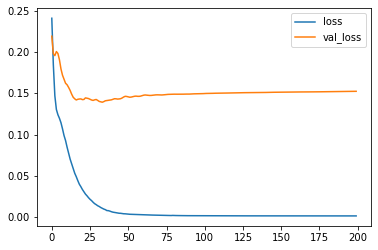

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.81 Fha:  0.02
label:  J Fh:  0.50 Fha:  0.53
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.62 Fha:  0.38
label:  c Fh:  0.51 Fha:  0.55
label:  f Fh:  0.62 Fha:  0.31
label:  j Fh:  0.22 Fha:  0.69
label:  k Fh:  0.80 Fha:  0.17
label:  m Fh:  0.45 Fha:  0.24
label:  n Fh:  0.81 Fha:  0.25
label:  o Fh:  0.66 Fha:  0.29
label:  p Fh:  0.53 Fha:  0.25
label:  q Fh:  0.51 Fha:  0.39
label:  r Fh:  0.60 Fha:  0.49
label:  s Fh:  0.38 Fha:  0.53
label:  u Fh:  0.76 Fha:  0.28
label:  v Fh:  0.28 Fha:  0.68
label:  w Fh:  0.41 Fha:  0.48
label:  x Fh:  0.29 Fha:  0.67
label:  y Fh:  0.15 Fha:  0.77
label:  z Fh:  0.33 Fha:  0.53
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.57 Fha:  0.39
label:  3 Fh:  0.72 Fha:  0.27
label:  5 Fh:  0.71 Fha:  0.22
label:  6 Fh:  0.68 Fha:  0.11
label:  7 Fh:  0.46 Fha:  0.49
label:  8 Fh:  0.72 Fha:  0.18
label:  9 Fh:  0.77 Fha:  0.21
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.82 Fha:  0.38


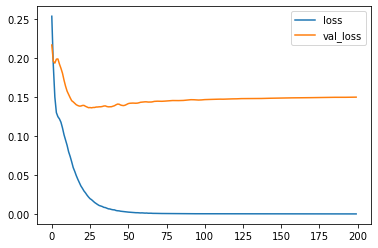

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.77 Fha:  0.02
label:  J Fh:  0.43 Fha:  0.53
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.59 Fha:  0.37
label:  c Fh:  0.44 Fha:  0.53
label:  f Fh:  0.64 Fha:  0.32
label:  j Fh:  0.20 Fha:  0.71
label:  k Fh:  0.77 Fha:  0.16
label:  m Fh:  0.45 Fha:  0.27
label:  n Fh:  0.79 Fha:  0.28
label:  o Fh:  0.62 Fha:  0.38
label:  p Fh:  0.53 Fha:  0.25
label:  q Fh:  0.49 Fha:  0.35
label:  r Fh:  0.60 Fha:  0.47
label:  s Fh:  0.31 Fha:  0.57
label:  u Fh:  0.76 Fha:  0.28
label:  v Fh:  0.21 Fha:  0.72
label:  w Fh:  0.34 Fha:  0.53
label:  x Fh:  0.38 Fha:  0.64
label:  y Fh:  0.17 Fha:  0.74
label:  z Fh:  0.35 Fha:  0.53
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.59 Fha:  0.35
label:  3 Fh:  0.70 Fha:  0.25
label:  5 Fh:  0.75 Fha:  0.23
label:  6 Fh:  0.64 Fha:  0.10
label:  7 Fh:  0.46 Fha:  0.51
label:  8 Fh:  0.69 Fha:  0.20
label:  9 Fh:  0.79 Fha:  0.19
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.74 Fha:  0.40


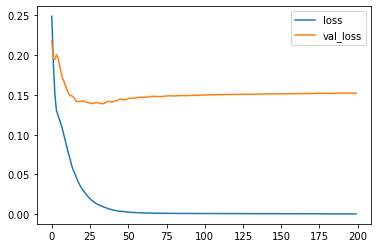

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.75 Fha:  0.02
label:  J Fh:  0.57 Fha:  0.50
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.64 Fha:  0.36
label:  c Fh:  0.54 Fha:  0.47
label:  f Fh:  0.60 Fha:  0.32
label:  j Fh:  0.20 Fha:  0.71
label:  k Fh:  0.79 Fha:  0.16
label:  m Fh:  0.36 Fha:  0.28
label:  n Fh:  0.81 Fha:  0.30
label:  o Fh:  0.64 Fha:  0.33
label:  p Fh:  0.62 Fha:  0.25
label:  q Fh:  0.55 Fha:  0.38
label:  r Fh:  0.58 Fha:  0.42
label:  s Fh:  0.38 Fha:  0.53
label:  u Fh:  0.77 Fha:  0.29
label:  v Fh:  0.23 Fha:  0.74
label:  w Fh:  0.40 Fha:  0.46
label:  x Fh:  0.40 Fha:  0.60
label:  y Fh:  0.15 Fha:  0.78
label:  z Fh:  0.35 Fha:  0.55
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.57 Fha:  0.37
label:  3 Fh:  0.68 Fha:  0.26
label:  5 Fh:  0.75 Fha:  0.23
label:  6 Fh:  0.67 Fha:  0.11
label:  7 Fh:  0.46 Fha:  0.51
label:  8 Fh:  0.70 Fha:  0.20
label:  9 Fh:  0.79 Fha:  0.21
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.71 Fha:  0.41


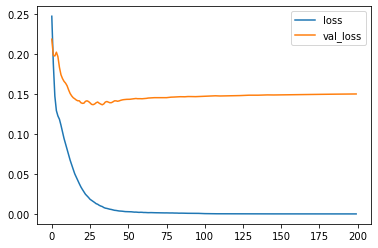

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.81 Fha:  0.02
label:  J Fh:  0.46 Fha:  0.55
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.61 Fha:  0.40
label:  c Fh:  0.49 Fha:  0.49
label:  f Fh:  0.62 Fha:  0.31
label:  j Fh:  0.20 Fha:  0.71
label:  k Fh:  0.79 Fha:  0.14
label:  m Fh:  0.40 Fha:  0.28
label:  n Fh:  0.81 Fha:  0.28
label:  o Fh:  0.62 Fha:  0.33
label:  p Fh:  0.56 Fha:  0.28
label:  q Fh:  0.52 Fha:  0.34
label:  r Fh:  0.60 Fha:  0.48
label:  s Fh:  0.35 Fha:  0.56
label:  u Fh:  0.76 Fha:  0.29
label:  v Fh:  0.23 Fha:  0.72
label:  w Fh:  0.43 Fha:  0.51
label:  x Fh:  0.42 Fha:  0.60
label:  y Fh:  0.19 Fha:  0.75
label:  z Fh:  0.33 Fha:  0.56
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.65 Fha:  0.36
label:  3 Fh:  0.70 Fha:  0.30
label:  5 Fh:  0.75 Fha:  0.23
label:  6 Fh:  0.67 Fha:  0.11
label:  7 Fh:  0.41 Fha:  0.54
label:  8 Fh:  0.69 Fha:  0.22
label:  9 Fh:  0.79 Fha:  0.21
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.76 Fha:  0.41


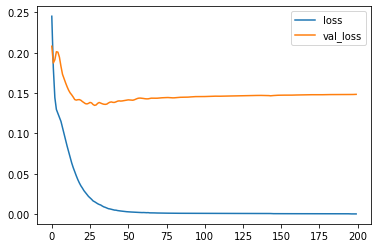

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.77 Fha:  0.02
label:  J Fh:  0.50 Fha:  0.54
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.64 Fha:  0.39
label:  c Fh:  0.54 Fha:  0.43
label:  f Fh:  0.62 Fha:  0.30
label:  j Fh:  0.22 Fha:  0.67
label:  k Fh:  0.77 Fha:  0.18
label:  m Fh:  0.39 Fha:  0.27
label:  n Fh:  0.87 Fha:  0.27
label:  o Fh:  0.64 Fha:  0.33
label:  p Fh:  0.62 Fha:  0.21
label:  q Fh:  0.58 Fha:  0.34
label:  r Fh:  0.60 Fha:  0.47
label:  s Fh:  0.38 Fha:  0.55
label:  u Fh:  0.81 Fha:  0.25
label:  v Fh:  0.31 Fha:  0.67
label:  w Fh:  0.37 Fha:  0.49
label:  x Fh:  0.36 Fha:  0.66
label:  y Fh:  0.06 Fha:  0.88
label:  z Fh:  0.35 Fha:  0.57
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.59 Fha:  0.37
label:  3 Fh:  0.70 Fha:  0.33
label:  5 Fh:  0.75 Fha:  0.23
label:  6 Fh:  0.64 Fha:  0.12
label:  7 Fh:  0.43 Fha:  0.55
label:  8 Fh:  0.72 Fha:  0.18
label:  9 Fh:  0.82 Fha:  0.20
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.79 Fha:  0.40


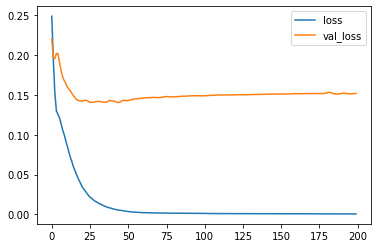

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.73 Fha:  0.02
label:  J Fh:  0.48 Fha:  0.53
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.67 Fha:  0.39
label:  c Fh:  0.49 Fha:  0.53
label:  f Fh:  0.60 Fha:  0.30
label:  j Fh:  0.22 Fha:  0.69
label:  k Fh:  0.77 Fha:  0.16
label:  m Fh:  0.40 Fha:  0.28
label:  n Fh:  0.84 Fha:  0.29
label:  o Fh:  0.64 Fha:  0.35
label:  p Fh:  0.58 Fha:  0.25
label:  q Fh:  0.58 Fha:  0.39
label:  r Fh:  0.65 Fha:  0.45
label:  s Fh:  0.42 Fha:  0.53
label:  u Fh:  0.79 Fha:  0.27
label:  v Fh:  0.26 Fha:  0.70
label:  w Fh:  0.34 Fha:  0.52
label:  x Fh:  0.42 Fha:  0.60
label:  y Fh:  0.15 Fha:  0.77
label:  z Fh:  0.33 Fha:  0.60
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.59 Fha:  0.36
label:  3 Fh:  0.72 Fha:  0.33
label:  5 Fh:  0.73 Fha:  0.22
label:  6 Fh:  0.67 Fha:  0.09
label:  7 Fh:  0.41 Fha:  0.55
label:  8 Fh:  0.73 Fha:  0.19
label:  9 Fh:  0.79 Fha:  0.23
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.82 Fha:  0.39


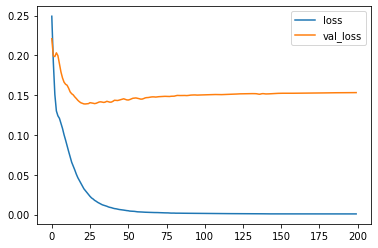

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.78 Fha:  0.04
label:  J Fh:  0.41 Fha:  0.59
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.58 Fha:  0.40
label:  c Fh:  0.49 Fha:  0.49
label:  f Fh:  0.62 Fha:  0.31
label:  j Fh:  0.20 Fha:  0.67
label:  k Fh:  0.79 Fha:  0.14
label:  m Fh:  0.39 Fha:  0.31
label:  n Fh:  0.85 Fha:  0.26
label:  o Fh:  0.62 Fha:  0.35
label:  p Fh:  0.48 Fha:  0.30
label:  q Fh:  0.52 Fha:  0.42
label:  r Fh:  0.58 Fha:  0.46
label:  s Fh:  0.38 Fha:  0.53
label:  u Fh:  0.74 Fha:  0.30
label:  v Fh:  0.28 Fha:  0.69
label:  w Fh:  0.41 Fha:  0.47
label:  x Fh:  0.38 Fha:  0.63
label:  y Fh:  0.17 Fha:  0.74
label:  z Fh:  0.28 Fha:  0.61
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.59 Fha:  0.37
label:  3 Fh:  0.70 Fha:  0.32
label:  5 Fh:  0.69 Fha:  0.25
label:  6 Fh:  0.65 Fha:  0.11
label:  7 Fh:  0.43 Fha:  0.55
label:  8 Fh:  0.72 Fha:  0.20
label:  9 Fh:  0.79 Fha:  0.23
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.74 Fha:  0.43


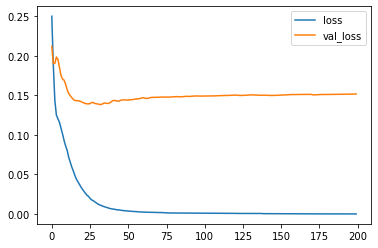

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.75 Fha:  0.02
label:  J Fh:  0.46 Fha:  0.55
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.64 Fha:  0.39
label:  c Fh:  0.44 Fha:  0.57
label:  f Fh:  0.64 Fha:  0.31
label:  j Fh:  0.18 Fha:  0.70
label:  k Fh:  0.79 Fha:  0.17
label:  m Fh:  0.41 Fha:  0.27
label:  n Fh:  0.81 Fha:  0.28
label:  o Fh:  0.62 Fha:  0.38
label:  p Fh:  0.58 Fha:  0.25
label:  q Fh:  0.51 Fha:  0.38
label:  r Fh:  0.60 Fha:  0.48
label:  s Fh:  0.33 Fha:  0.59
label:  u Fh:  0.77 Fha:  0.28
label:  v Fh:  0.31 Fha:  0.66
label:  w Fh:  0.37 Fha:  0.52
label:  x Fh:  0.42 Fha:  0.62
label:  y Fh:  0.15 Fha:  0.76
label:  z Fh:  0.35 Fha:  0.59
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.61 Fha:  0.39
label:  3 Fh:  0.70 Fha:  0.27
label:  5 Fh:  0.73 Fha:  0.22
label:  6 Fh:  0.67 Fha:  0.11
label:  7 Fh:  0.43 Fha:  0.57
label:  8 Fh:  0.76 Fha:  0.22
label:  9 Fh:  0.81 Fha:  0.21
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.71 Fha:  0.37


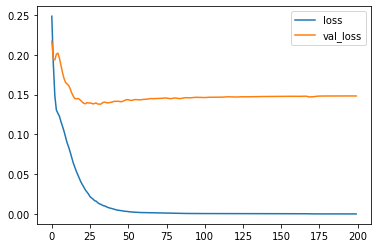

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.77 Fha:  0.02
label:  J Fh:  0.50 Fha:  0.57
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.69 Fha:  0.33
label:  c Fh:  0.54 Fha:  0.49
label:  f Fh:  0.62 Fha:  0.31
label:  j Fh:  0.16 Fha:  0.74
label:  k Fh:  0.80 Fha:  0.16
label:  m Fh:  0.41 Fha:  0.26
label:  n Fh:  0.82 Fha:  0.29
label:  o Fh:  0.66 Fha:  0.36
label:  p Fh:  0.60 Fha:  0.27
label:  q Fh:  0.56 Fha:  0.36
label:  r Fh:  0.60 Fha:  0.45
label:  s Fh:  0.46 Fha:  0.50
label:  u Fh:  0.81 Fha:  0.26
label:  v Fh:  0.28 Fha:  0.66
label:  w Fh:  0.40 Fha:  0.47
label:  x Fh:  0.42 Fha:  0.60
label:  y Fh:  0.15 Fha:  0.75
label:  z Fh:  0.37 Fha:  0.53
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.59 Fha:  0.32
label:  3 Fh:  0.72 Fha:  0.27
label:  5 Fh:  0.73 Fha:  0.23
label:  6 Fh:  0.65 Fha:  0.11
label:  7 Fh:  0.39 Fha:  0.49
label:  8 Fh:  0.70 Fha:  0.20
label:  9 Fh:  0.79 Fha:  0.23
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.74 Fha:  0.40


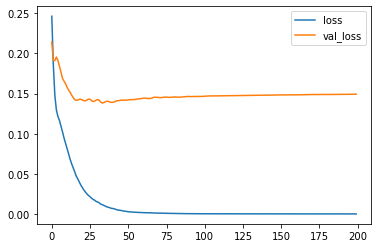

label:  F Fh:  1.00 Fha:  0.15
label:  G Fh:  0.73 Fha:  0.02
label:  J Fh:  0.43 Fha:  0.57
label:  T Fh:  0.96 Fha:  0.18
label:  a Fh:  0.70 Fha:  0.39
label:  c Fh:  0.46 Fha:  0.53
label:  f Fh:  0.60 Fha:  0.32
label:  j Fh:  0.22 Fha:  0.69
label:  k Fh:  0.79 Fha:  0.14
label:  m Fh:  0.45 Fha:  0.22
label:  n Fh:  0.85 Fha:  0.29
label:  o Fh:  0.64 Fha:  0.33
label:  p Fh:  0.56 Fha:  0.28
label:  q Fh:  0.56 Fha:  0.41
label:  r Fh:  0.63 Fha:  0.46
label:  s Fh:  0.44 Fha:  0.51
label:  u Fh:  0.77 Fha:  0.28
label:  v Fh:  0.26 Fha:  0.70
label:  w Fh:  0.43 Fha:  0.45
label:  x Fh:  0.36 Fha:  0.64
label:  y Fh:  0.12 Fha:  0.80
label:  z Fh:  0.37 Fha:  0.53
label:  1 Fh:  0.92 Fha:  0.16
label:  2 Fh:  0.59 Fha:  0.35
label:  3 Fh:  0.70 Fha:  0.26
label:  5 Fh:  0.76 Fha:  0.22
label:  6 Fh:  0.64 Fha:  0.13
label:  7 Fh:  0.37 Fha:  0.53
label:  8 Fh:  0.70 Fha:  0.21
label:  9 Fh:  0.79 Fha:  0.22
label:  0 Fh:  0.80 Fha:  0.08
label:  ! Fh:  0.76 Fha:  0.42
[[1.    

In [57]:
matrix = []
dev = [0, 0.001, 0.002, 0.003, 0.005,  0.01, 0.02, 0.03, 0.05, 0.1]  
for d in dev:
    fhs, fhas = train_process3(train_idx, test_idx, d, 200)
    matrix.append(fhs)
    matrix.append(fhas)
matrix = np.transpose(np.array(matrix))
print(matrix)
samples = [label2name[i] for i in test_idx]

header = []
for n in dev:
    header.append((str(n), 'Fh'))
    header.append((str(n), 'Fha'))
print(header)
header = pd.MultiIndex.from_tuples(header)
df = pd.DataFrame(matrix, dtype='float', index=samples, columns=header)
df = df.round(2)
df.to_excel("metric_2.xlsx", index = True, header=True)

print(matrix)
print(samples)

In [58]:
cols = []
for n in dev:
    cols.append((str(n), 'Fh'))
test_Fh = np.transpose(df[cols].values)
cols = []
for n in dev:
    cols.append((str(n), 'Fha'))
test_Fha = np.transpose(df[cols].values)

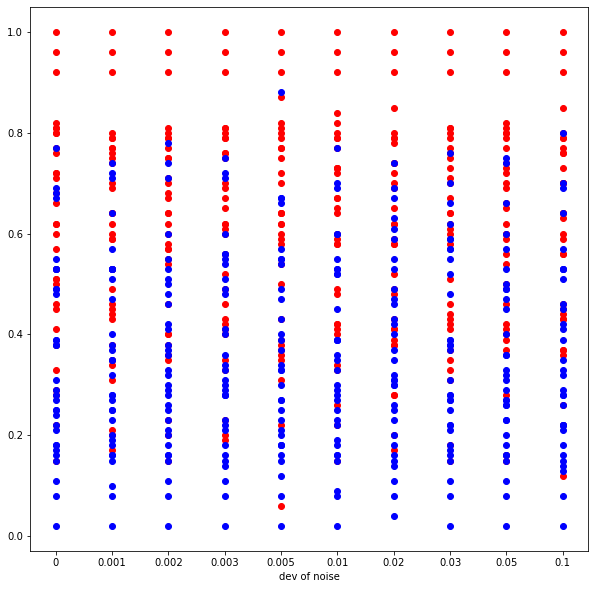

In [59]:
plt.figure(figsize=(10, 10))

for i in range(10):
    fh = test_Fh[i]
    fha = test_Fha[i]
    plt.scatter([i]*32, fh, color='r')
    plt.scatter([i]*32, fha, color='b')

plt.xticks(np.arange(10), dev)
plt.xlabel('dev of noise')
plt.show()